<a href="https://colab.research.google.com/github/WilliamShengYangHuang/RC18_Machine_Learning/blob/main/Pix2Pix_mod_beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Making Design with Pix2Pix**

Original Development: Image-to-Image Translation with Conditional Adversarial Nets: https://phillipi.github.io/pix2pix/

Paper available at https://arxiv.org/abs/1611.07004


Modified from the version published at https://www.tensorflow.org/tutorials/generative/pix2pix
(Last modified on 1 December 2022 by William Huang ucfnhua@ucl.ac.uk).



---
Input image resolution: [(256, 256), (256, 256)]


Input image example:

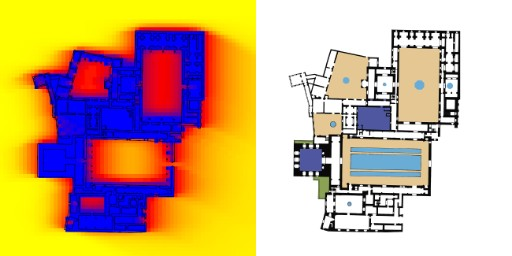

Conditional image example:

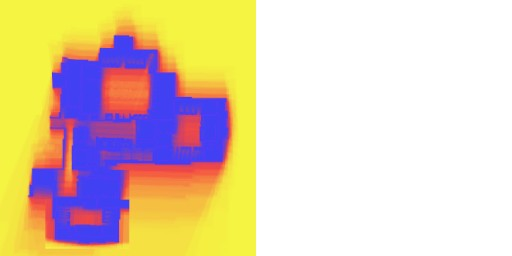

Image data format: .jpg or .png

Datasets structure: a google drive folder incorporating three subfolders named 'train', 'test', 'val'



---
Segmentation scheme:

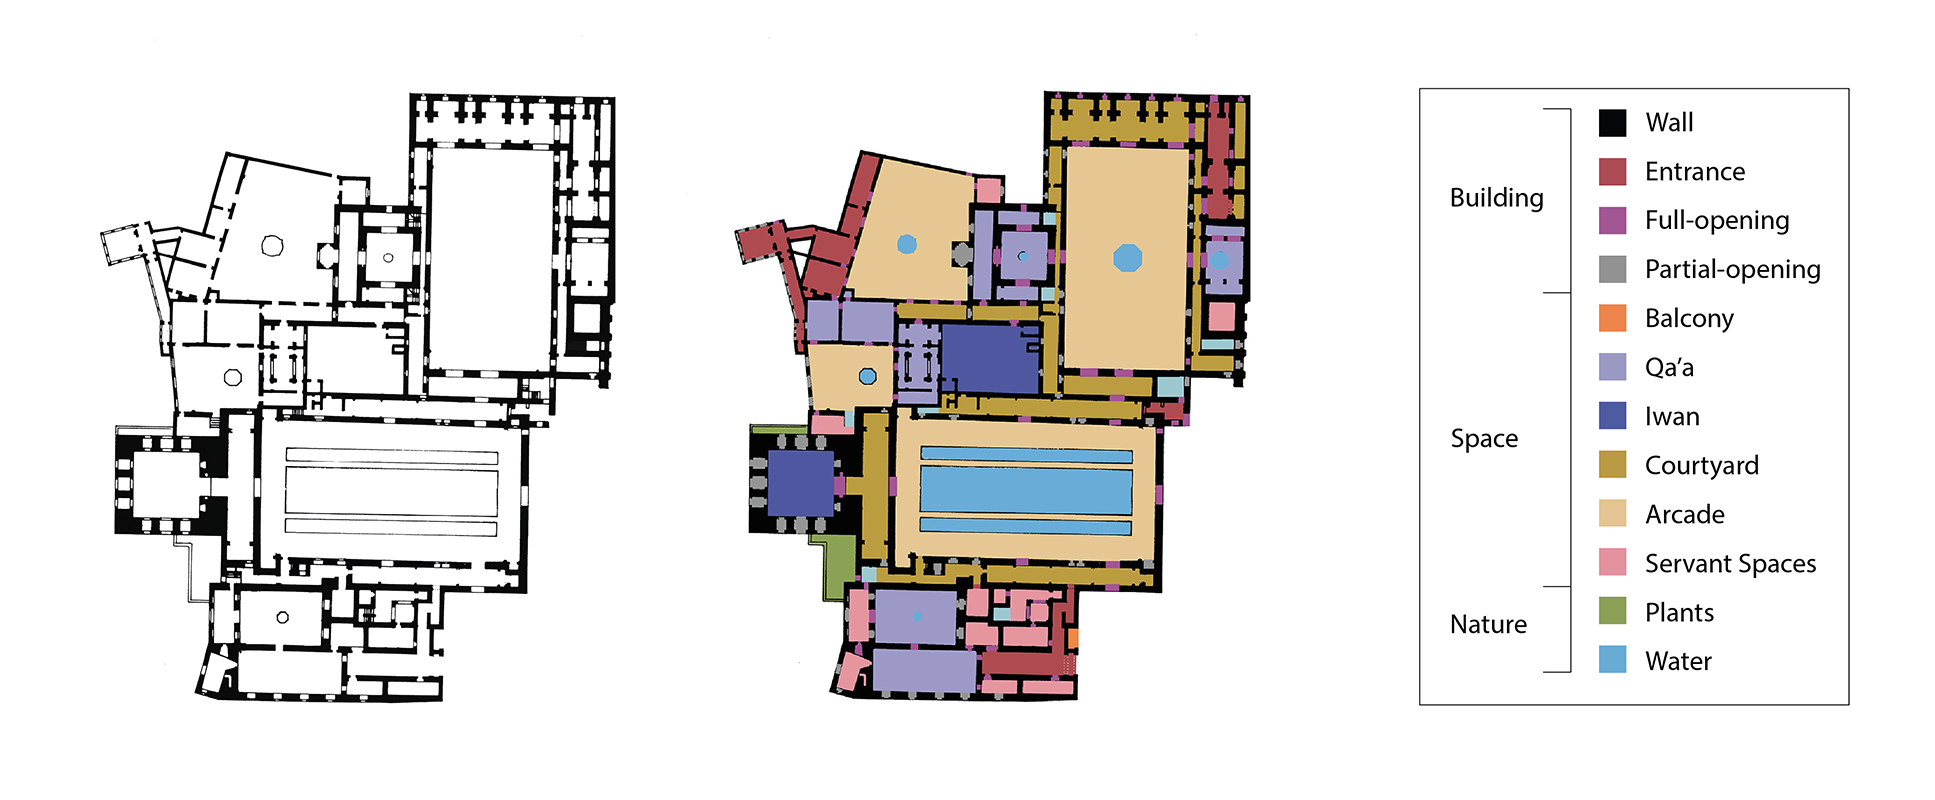

## Import libraries

In [1]:
import os
import sys
import time
import numpy as np

import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
from IPython import display

from google.colab import drive

## List devices

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5150988000213958529
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14410383360
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 267592774726995557
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

## Load the dataset

In [3]:
# Place the dataset in your Google Drive
drive.mount("/content/drive")
"""
######## set dataset path ########-------------------------------------------------------------------------
folder_name = 'ml_test_20220105' #@param{type:"string"}
path = "/content/drive/My Drive/" + folder_name
# path = "/content/drive/My Drive/ml_test/0.jpg

os.chdir(path) # change the current working directory to the given path
os.listdir(path) # list all the entries in the directory given by path
"""

Mounted at /content/drive


'\n######## set dataset path ########-------------------------------------------------------------------------\nfolder_name = \'ml_test_20220105\' #@param{type:"string"}\npath = "/content/drive/My Drive/" + folder_name \n# path = "/content/drive/My Drive/ml_test/0.jpg\n\nos.chdir(path) # change the current working directory to the given path\nos.listdir(path) # list all the entries in the directory given by path\n'

In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

def load(input_image_file, real_image_file):
    # Load and decode the input image
    input_image = tf.io.read_file(input_image_file)
    input_image = tf.image.decode_jpeg(input_image)

    # Load and decode the real image
    real_image = tf.io.read_file(real_image_file)
    real_image = tf.image.decode_jpeg(real_image)

    # Cast the images to float32
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

# Example usage
input_image_file = '/content/drive/My Drive/cycle/a/0.JPG'  # Replace with the path to your input image
real_image_file = '/content/drive/My Drive/cycle/b/0.JPG'    # Replace with the path to your real image

input_image, real_image = load(input_image_file, real_image_file)


## Plot input-target sample

In [5]:
path_input = '/content/drive/My Drive/cycle/a'
path_real = '/content/drive/My Drive/cycle/b'
path_condition = '/content/drive/My Drive/cycle/c'

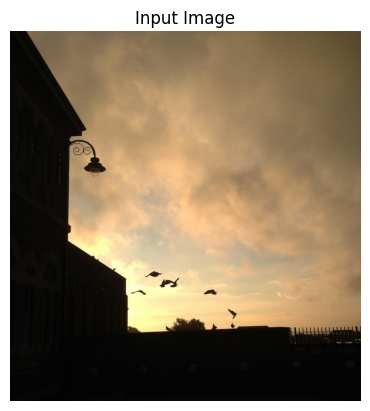

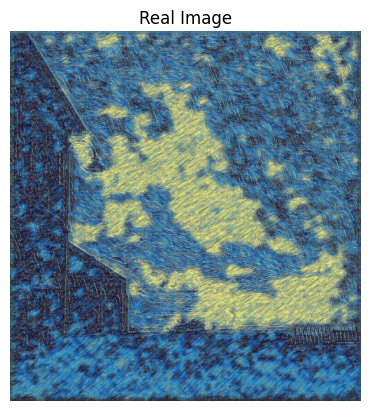

In [6]:
file_name = 0 #@param {type:"slider", min:0, max:29, step:1}
file_format = '.JPG' #@param [".jpg", ".png", ".bmp"] {allow-input: true}

# Construct the file paths
input_image_file = os.path.join(path_input, f'{file_name}{file_format}')
real_image_file = os.path.join(path_real, f'{file_name}{file_format}')  # Update as per the correct path

# Load the images
inp, re = load(input_image_file, real_image_file)

# Display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.title('Input Image')
plt.axis('off')

plt.figure()
plt.imshow(re / 255.0)
plt.title('Real Image')
plt.axis('off')

plt.show()

## Data preprocessing & augmentation

In [7]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

# normalising the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
  # resising to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

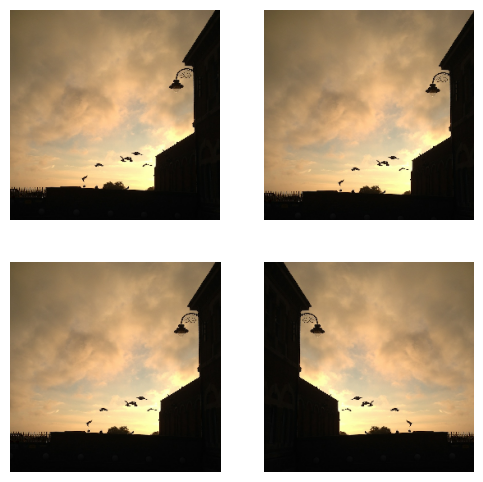

In [8]:
# inspect some of the preprocessed output
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [9]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_val(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Input pipeline

In [10]:
"""train_dataset = tf.data.Dataset.list_files(path+'/train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)"""

"train_dataset = tf.data.Dataset.list_files(path+'/train/*.jpg')\ntrain_dataset = train_dataset.map(load_image_train,\n                                  num_parallel_calls=tf.data.AUTOTUNE)\ntrain_dataset = train_dataset.shuffle(BUFFER_SIZE)\ntrain_dataset = train_dataset.batch(BATCH_SIZE)"

In [11]:
# Adjust the load function to work with separate paths
def load_image_train(file_path):
    # Extract the file name and construct file paths for input and real images
    file_name = tf.strings.split(file_path, os.sep)[-1]
    input_image_file = tf.strings.join([path_input, file_name], separator=os.sep)
    real_image_file = tf.strings.join([path_real, file_name], separator=os.sep)

    # Load the input and real images
    input_image, real_image = load(input_image_file, real_image_file)
    return input_image, real_image

# Create the training dataset
train_dataset = tf.data.Dataset.list_files(path_input + '/*.JPG')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [12]:
"""test_dataset = tf.data.Dataset.list_files(path+'/test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)"""

"test_dataset = tf.data.Dataset.list_files(path+'/test/*.jpg')\ntest_dataset = test_dataset.map(load_image_test)\ntest_dataset = test_dataset.batch(BATCH_SIZE)"

In [13]:
# Define the load_image_test function
def load_image_test(file_path):
    # Extract the file name and construct file paths for input and real images
    file_name = tf.strings.split(file_path, os.sep)[-1]
    input_image_file = tf.strings.join([path_input, file_name], separator=os.sep)
    real_image_file = tf.strings.join([path_real, file_name], separator=os.sep)

    # Load the input and real images
    input_image, real_image = load(input_image_file, real_image_file)
    return input_image, real_image

# Create the test dataset
test_dataset = tf.data.Dataset.list_files(path_real + '/*.JPG')  # Update the path as needed
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Code to process the dataset further...


In [14]:
"""val_dataset = tf.data.Dataset.list_files(path+'/val/*.jpg')
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)"""

"val_dataset = tf.data.Dataset.list_files(path+'/val/*.jpg')\nval_dataset = val_dataset.map(load_image_val)\nval_dataset = val_dataset.batch(BATCH_SIZE)"

In [15]:
"""# Define the load_image_val function
def load_image_val(file_path):
    # Extract the file name and construct file paths for input, real, and condition images
    file_name = tf.strings.split(file_path, os.sep)[-1]
    input_image_file = tf.strings.join([path_input, file_name], separator=os.sep)
    real_image_file = tf.strings.join([path_real, file_name], separator=os.sep)
    condition_image_file = tf.strings.join([path_condition, file_name], separator=os.sep)

    # Load the input, real, and condition images
    input_image, real_image = load(input_image_file, real_image_file)
    condition_image, _ = load(condition_image_file, condition_image_file)  # Assuming condition_image is needed

    return input_image, real_image, condition_image

# Create the validation dataset
val_dataset = tf.data.Dataset.list_files(os.path.join(path_condition + '/*.JPG'))
val_dataset = val_dataset.map(load_image_val, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Code to process the dataset further..."""


"# Define the load_image_val function\ndef load_image_val(file_path):\n    # Extract the file name and construct file paths for input, real, and condition images\n    file_name = tf.strings.split(file_path, os.sep)[-1]\n    input_image_file = tf.strings.join([path_input, file_name], separator=os.sep)\n    real_image_file = tf.strings.join([path_real, file_name], separator=os.sep)\n    condition_image_file = tf.strings.join([path_condition, file_name], separator=os.sep)\n\n    # Load the input, real, and condition images\n    input_image, real_image = load(input_image_file, real_image_file)\n    condition_image, _ = load(condition_image_file, condition_image_file)  # Assuming condition_image is needed\n\n    return input_image, real_image, condition_image\n\n# Create the validation dataset\nval_dataset = tf.data.Dataset.list_files(os.path.join(path_condition + '/*.JPG'))\nval_dataset = val_dataset.map(load_image_val, num_parallel_calls=tf.data.AUTOTUNE)\nval_dataset = val_dataset.batch(

In [16]:
def load_image_val(file_path):
    # Extract the file name and construct file paths
    file_name = tf.strings.split(file_path, os.sep)[-1]
    input_image_file = tf.strings.join([path_input, file_name], separator=os.sep)
    real_image_file = tf.strings.join([path_real, file_name], separator=os.sep)
    condition_image_file = tf.strings.join([path_condition, file_name], separator=os.sep)

    # Load the images
    input_image, real_image = load(input_image_file, real_image_file)
    condition_image, _ = load(condition_image_file, condition_image_file)

    # Process the images: normalize, center crop, and resize
    input_image = process_image(input_image)
    real_image = process_image(real_image)
    condition_image = process_image(condition_image)

    return input_image, real_image, condition_image

def process_image(image):
    # Normalize the image to the range [-1, 1]
    image = (image / 127.5) - 1

    # Center crop and resize
    # Assuming images are larger than 256x256, adjust as needed
    image = tf.image.resize_with_crop_or_pad(image, target_height=256, target_width=256)
    image = tf.image.resize(image, [256, 256])

    return image


# Create the validation dataset
val_dataset = tf.data.Dataset.list_files(os.path.join(path_condition, '*.JPG'))
val_dataset = val_dataset.map(load_image_val, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)


## Build generator (U-Net)

In [17]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 422, 400, 3)
(1, 844, 800, 3)


In [18]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 128, 128, 64)         3072      ['input_1[0][0]']             
                                                                                                  
 sequential_3 (Sequential)   (None, 64, 64, 128)          131584    ['sequential_2[0][0]']        
                                                                                                  
 sequential_4 (Sequential)   (None, 32, 32, 256)          525312    ['sequential_3[0][0]']        
                                                                                              

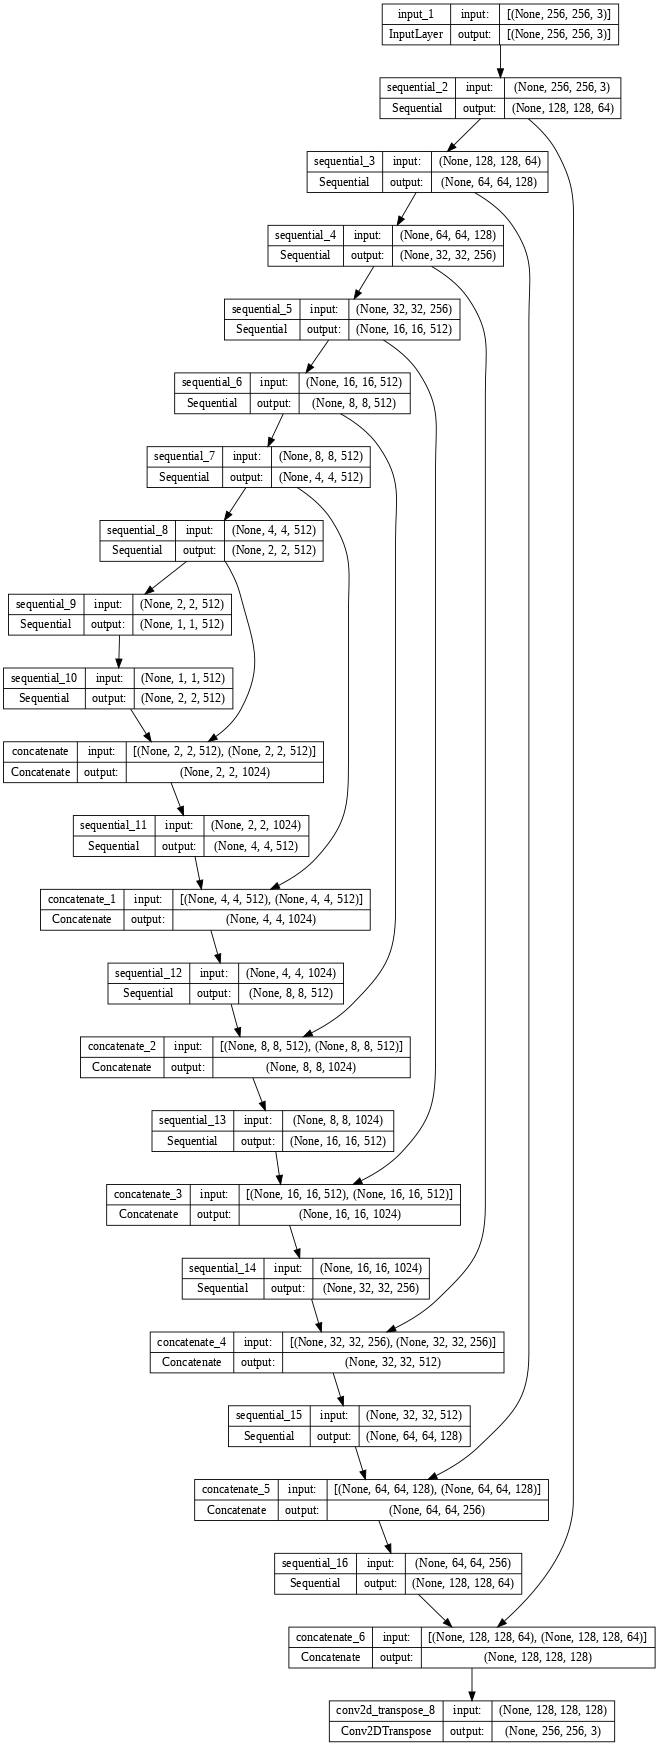

In [19]:
generator = Generator()
generator.summary()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [20]:
"""gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])"""

'gen_output = generator(inp[tf.newaxis,...], training=False)\nplt.imshow(gen_output[0,...])'

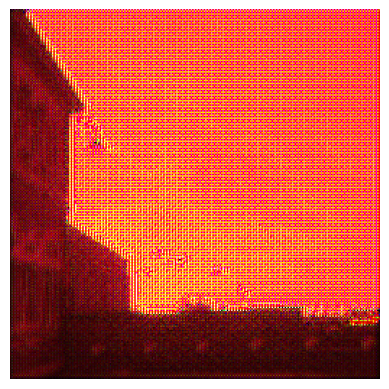

In [21]:
# ... [Previous code where inp image is loaded and processed]

# Assuming inp is your input image
# Resize the image to 256x256 pixels
inp_resized = tf.image.resize(inp, [256, 256])

# Now use the resized image with the generator
gen_output = generator(inp_resized[tf.newaxis, ...], training=False)

# Display the generated output
plt.imshow(gen_output[0, ...])
plt.axis('off')
plt.show()

# ... [Rest of your code]


## Build discriminator

Shape after resizing:
inp_resized: (256, 256, 3)
gen_output_resized: (1, 256, 256, 3)

Shape after adding batch dimension:
inp_resized_batch: (1, 256, 256, 3)
gen_output_resized: (1, 256, 256, 3)


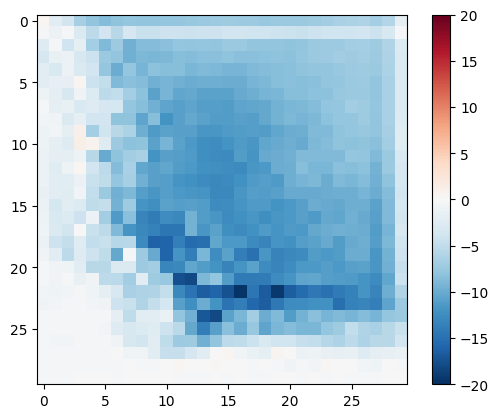

In [22]:
LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

# Ensure the resized images have the correct shape
inp_resized = tf.image.resize(inp, [256, 256])
gen_output_resized = tf.image.resize(gen_output, [256, 256])

# Add a batch dimension only to the inp_resized
inp_resized_batch = tf.expand_dims(inp_resized, axis=0)

# Confirming the shapes
print("Shape after resizing:")
print("inp_resized:", inp_resized.shape)
print("gen_output_resized:", gen_output_resized.shape)

print("\nShape after adding batch dimension:")
print("inp_resized_batch:", inp_resized_batch.shape)
print("gen_output_resized:", gen_output_resized.shape)  # No extra batch dimension added

# Now use the batched images with the discriminator
disc_out = discriminator([inp_resized_batch, gen_output_resized], training=False)

# Display the discriminator output
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
plt.show()



loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Define loss functions and optimiser

In [23]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [25]:
# set checkpoints
checkpoint_dir = '/content/drive/My Drive/test_training_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

In [26]:
"""def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]

  ######## Edit image titles (modify as needed)########------------------------
  title_domain_A = 'Input' #@param {type:"string"}
  title_domain_B = 'Ground Truth' #@param {type:"string"}
  title_prediction = 'Prediction' #@param {type:"string"}
  title = [title_domain_A, title_domain_B, title_prediction]

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig('generated_image.png')
  plt.show()

for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)  """

'def generate_images(model, test_input, tar):\n  prediction = model(test_input, training=True)\n  plt.figure(figsize=(15,15))\n\n  display_list = [test_input[0], tar[0], prediction[0]]\n\n  ######## Edit image titles (modify as needed)########------------------------\n  title_domain_A = \'Input\' #@param {type:"string"}\n  title_domain_B = \'Ground Truth\' #@param {type:"string"}\n  title_prediction = \'Prediction\' #@param {type:"string"}\n  title = [title_domain_A, title_domain_B, title_prediction] \n\n  for i in range(3):\n    plt.subplot(1, 3, i+1)\n    plt.title(title[i])\n    # getting the pixel values between [0, 1] to plot it.\n    plt.imshow(display_list[i] * 0.5 + 0.5)\n    plt.axis(\'off\')\n  plt.savefig(\'generated_image.png\')  \n  plt.show()  \n\nfor example_input, example_target in test_dataset.take(1):\n  generate_images(generator, example_input, example_target)  '

In [27]:
"""def generate_images(model, test_input, tar):
    # Ensure the test_input and tar are of the correct shape
    if len(test_input.shape) > 4:  # Check if there's an extra dimension
        test_input = tf.squeeze(test_input, axis=0)  # Remove the extra dimension
    if len(tar.shape) > 4:  # Check if there's an extra dimension
        tar = tf.squeeze(tar, axis=0)  # Remove the extra dimension

    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title_domain_A = 'Input' #@param {type:"string"}
    title_domain_B = 'Ground Truth' #@param {type:"string"}
    title_prediction = 'Prediction' #@param {type:"string"}
    title = [title_domain_A, title_domain_B, title_prediction]
    #title = ['Input', 'Ground Truth', 'Prediction']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.savefig('generated_image.png')
    plt.show()

# Test the model with one example from the dataset
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)"""


'def generate_images(model, test_input, tar):\n    # Ensure the test_input and tar are of the correct shape\n    if len(test_input.shape) > 4:  # Check if there\'s an extra dimension\n        test_input = tf.squeeze(test_input, axis=0)  # Remove the extra dimension\n    if len(tar.shape) > 4:  # Check if there\'s an extra dimension\n        tar = tf.squeeze(tar, axis=0)  # Remove the extra dimension\n\n    prediction = model(test_input, training=True)\n    plt.figure(figsize=(15,15))\n\n    display_list = [test_input[0], tar[0], prediction[0]]\n    title_domain_A = \'Input\' #@param {type:"string"}\n    title_domain_B = \'Ground Truth\' #@param {type:"string"}\n    title_prediction = \'Prediction\' #@param {type:"string"}\n    title = [title_domain_A, title_domain_B, title_prediction] \n    #title = [\'Input\', \'Ground Truth\', \'Prediction\']\n\n    for i in range(3):\n        plt.subplot(1, 3, i+1)\n        plt.title(title[i])\n        plt.imshow(display_list[i] * 0.5 + 0.5)\n      

Example input shape: (1, 256, 256, 3)
Example target shape: (1, 256, 256, 3)


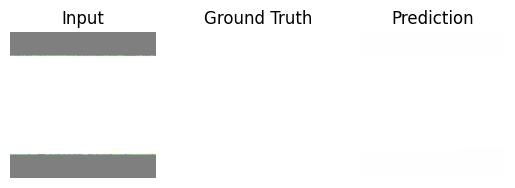

In [49]:
def load_image_test(file_path):
    # Extract the file name and construct file paths for input and real images
    file_name = tf.strings.split(file_path, os.sep)[-1]
    input_image_file = tf.strings.join([path_input, file_name], separator=os.sep)
    real_image_file = tf.strings.join([path_real, file_name], separator=os.sep)

    # Load the input and real images
    input_image, real_image = load(input_image_file, real_image_file)

    # Resize images to the desired size (256, 256)
    input_image = tf.image.resize(input_image, [256, 256])
    real_image = tf.image.resize(real_image, [256, 256])

    return input_image, real_image

test_dataset = tf.data.Dataset.list_files(path_real + '/*.JPG')
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

def generate_images(model, test_input, tar):
    # Ensure the test_input and tar are of the correct shape
    if len(test_input.shape) > 4:
        test_input = tf.squeeze(test_input, axis=0)
    if len(tar.shape) > 4:
        tar = tf.squeeze(tar, axis=0)

    prediction = model(test_input, training=True)
    display_list = [test_input[0], tar[0], prediction[0]]
    title_domain_A = 'Input' #@param {type:"string"}
    title_domain_B = 'Ground Truth' #@param {type:"string"}
    title_prediction = 'Prediction' #@param {type:"string"}
    title = [title_domain_A, title_domain_B, title_prediction]
    #title = ['Input', 'Ground Truth', 'Prediction']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.savefig('generated_image.png')
    plt.show()

for example_input, example_target in test_dataset.take(1):
    print("Example input shape:", example_input.shape)
    print("Example target shape:", example_target.shape)
    generate_images(generator, example_input, example_target)



## Training

In [50]:
EPOCHS = 30 #@param {type:"slider", min:1, max:1000, step:1}
######## set epochs number ########--------------------------------------------

import datetime
log_dir="/content/drive/My Drive/test_logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [51]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [52]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs ------------------------------------------------------------------------------------
    saving_frequency = 15 #@param {type:"slider", min:1, max:100, step:1}
    if (epoch + 1) % saving_frequency == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

In [32]:
#!pip install -U tensorboard

In [33]:
"""display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")"""

'display.IFrame(\n    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",\n    width="100%",\n    height="1000px")'

In [34]:
"""def resize_input_target(image_pair):
    input_image, target_image = image_pair
    # Remove extra dimensions if present
    input_image = tf.squeeze(input_image, axis=[0, 1])
    target_image = tf.squeeze(target_image, axis=[0, 1])

    # Resize the input and target images
    input_image_resized = tf.image.resize(input_image, [256, 256])
    target_image_resized = tf.image.resize(target_image, [256, 256])

    return input_image_resized, target_image_resized

train_dataset = train_dataset.map(resize_input_target)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = test_dataset.map(resize_input_target)
test_dataset = test_dataset.batch(BATCH_SIZE)

for input_image, target in train_dataset.take(1):
    print("Input image shape:", input_image.shape)  # Should be (batch_size, 256, 256, 3)
    print("Target image shape:", target.shape)      # Should be (batch_size, 256, 256, 3)

fit(train_dataset, EPOCHS, test_dataset)"""


'def resize_input_target(image_pair):\n    input_image, target_image = image_pair\n    # Remove extra dimensions if present\n    input_image = tf.squeeze(input_image, axis=[0, 1])\n    target_image = tf.squeeze(target_image, axis=[0, 1])\n\n    # Resize the input and target images\n    input_image_resized = tf.image.resize(input_image, [256, 256])\n    target_image_resized = tf.image.resize(target_image, [256, 256])\n\n    return input_image_resized, target_image_resized\n\ntrain_dataset = train_dataset.map(resize_input_target)\ntrain_dataset = train_dataset.batch(BATCH_SIZE)\n\ntest_dataset = test_dataset.map(resize_input_target)\ntest_dataset = test_dataset.batch(BATCH_SIZE)\n\nfor input_image, target in train_dataset.take(1):\n    print("Input image shape:", input_image.shape)  # Should be (batch_size, 256, 256, 3)\n    print("Target image shape:", target.shape)      # Should be (batch_size, 256, 256, 3)\n\nfit(train_dataset, EPOCHS, test_dataset)'

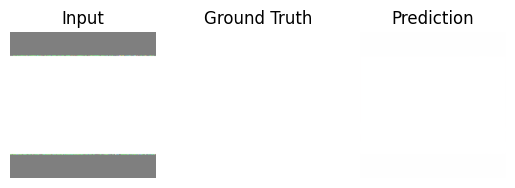

Epoch:  29
................................
Time taken for epoch 30 is 9.887045621871948 sec



In [53]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}
def resize_input_target(input_image, target_image):
    # Assuming input_image and target_image are already tensors with shape (1, 256, 256, 3)
    # Remove extra dimensions if present
    input_image = tf.squeeze(input_image, axis=0)
    target_image = tf.squeeze(target_image, axis=0)

    # Resize the input and target images
    input_image_resized = tf.image.resize(input_image, [256, 256])
    target_image_resized = tf.image.resize(target_image, [256, 256])

    return input_image_resized, target_image_resized

train_dataset = train_dataset.map(lambda x, y: resize_input_target(x, y))
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = test_dataset.map(lambda x, y: resize_input_target(x, y))
test_dataset = test_dataset.batch(BATCH_SIZE)


fit(train_dataset, EPOCHS, test_dataset)


In [36]:
"""#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir {log_dir}
fit(train_dataset, EPOCHS, test_dataset)"""

'#docs_infra: no_execute\n%load_ext tensorboard\n%tensorboard --logdir {log_dir}\nfit(train_dataset, EPOCHS, test_dataset)'

In [37]:
"""def load(image_file_1, image_file_2):
    # Load images from image_file_1 and image_file_2
    # ...

    # Resize images to the desired size (256, 256)
    image_1 = tf.image.resize(image_1, [256, 256])
    image_2 = tf.image.resize(image_2, [256, 256])

    # Further processing if needed
    # ...

    return image_1, image_2

for input_image, target in train_dataset.take(1):
    print("Input image shape:", input_image.shape)  # Should be (batch_size, 256, 256, 3)
    print("Target image shape:", target.shape)      # Should be (batch_size, 256, 256, 3)

def train_step(input_image, target, epoch):
    # Ensure the tensors are of the correct shape
    if len(input_image.shape) == 5:  # Check for extra batch dimension
        input_image = tf.squeeze(input_image, axis=1)
    if len(target.shape) == 5:
        target = tf.squeeze(target, axis=1)

    with tf.GradientTape() as tape:
        gen_output = generator(input_image, training=True)
        # Rest of your train_step logic...

fit(train_dataset, EPOCHS, test_dataset)"""


'def load(image_file_1, image_file_2):\n    # Load images from image_file_1 and image_file_2\n    # ...\n\n    # Resize images to the desired size (256, 256)\n    image_1 = tf.image.resize(image_1, [256, 256])\n    image_2 = tf.image.resize(image_2, [256, 256])\n\n    # Further processing if needed\n    # ...\n\n    return image_1, image_2\n\nfor input_image, target in train_dataset.take(1):\n    print("Input image shape:", input_image.shape)  # Should be (batch_size, 256, 256, 3)\n    print("Target image shape:", target.shape)      # Should be (batch_size, 256, 256, 3)\n\ndef train_step(input_image, target, epoch):\n    # Ensure the tensors are of the correct shape\n    if len(input_image.shape) == 5:  # Check for extra batch dimension\n        input_image = tf.squeeze(input_image, axis=1)\n    if len(target.shape) == 5:\n        target = tf.squeeze(target, axis=1)\n\n    with tf.GradientTape() as tape:\n        gen_output = generator(input_image, training=True)\n        # Rest of you

In [38]:
# !tensorboard dev upload --logdir  {log_dir}

## Restore the latest checkpoint and test

In [54]:
!ls {checkpoint_dir}
print(checkpoint_dir)

ls: cannot access '/content/drive/My': No such file or directory
ls: cannot access 'Drive/test_training_checkpoints/': No such file or directory
/content/drive/My Drive/test_training_checkpoints/


In [55]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create with the given design conditions
The condition images should be placed in the val dataset; this cell will use the images to generate the corresponding solutions.

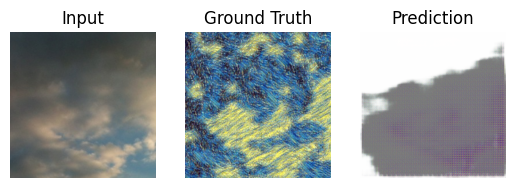

In [57]:
for element in val_dataset:
    inp, tar, _ = element  # Unpack all three items, ignore the third if not needed
    generate_images(generator, inp, tar)